In [1]:
from __future__ import print_function, division
import torchvision.datasets as dset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os, sys
import copy


img_size = 300
width, height = img_size, img_size
IMG_SIZE = (width, height)


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "C:\\Users\\noname\\Desktop\\Casting\\casting_data"


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn

# Assuming `data` is your dataset object
class_names = {'def_front', 'ok_front'}

# Load pre-trained VGG16 model
model_ft = models.vgg16(pretrained=True)

# Get the number of input features for the last fully connected layer
num_ftrs = model_ft.classifier[6].in_features 

# Replace the last fully connected layer with a new one that matches the number of classes in your dataset
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model_ft = model_ft.to(device)

# Freeze all layers except the new fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier[6].parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
num_epochs = 10

for epoch in range(num_epochs):
    model_ft.train()
    total_loss = 0.0
    total_correct = 0

    for images, labels in dataloaders['train']:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += torch.sum(preds == labels.data)

    epoch_loss = total_loss / dataset_sizes['train']
    epoch_acc = total_correct.double() / dataset_sizes['train']

    print('Epoch {}/{}'.format(epoch, num_epochs - 1), 'Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()

print('Training complete')

Epoch 0/9 Train Loss: 0.3417 Acc: 0.8422

Epoch 1/9 Train Loss: 0.3136 Acc: 0.8705

Epoch 2/9 Train Loss: 0.3077 Acc: 0.8735

Epoch 3/9 Train Loss: 0.3150 Acc: 0.8750

Epoch 4/9 Train Loss: 0.3048 Acc: 0.8737

Epoch 5/9 Train Loss: 0.3088 Acc: 0.8820

Epoch 6/9 Train Loss: 0.2988 Acc: 0.8881

Epoch 7/9 Train Loss: 0.3085 Acc: 0.8823

Epoch 8/9 Train Loss: 0.3186 Acc: 0.8800

Epoch 9/9 Train Loss: 0.3104 Acc: 0.8823

Training complete


In [3]:
PATH = "C:\\Users\\noname\\Desktop\\Casting_GradCAM_VGG16(pre-trained).pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4]:
model_ft.features[26:]

Sequential(
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
for param in model_ft.parameters():
    param.requires_grad = False

features_finetune_from = 26
for param in model_ft.features[features_finetune_from:].parameters():
    param.requires_grad = True

for param in model_ft.classifier.parameters():
    param.requires_grad = False

model_ft = model_ft.to(device)
optimizer_conv = optim.Adam(model_ft.parameters(), lr=0.0001)

In [6]:
num_epochs = 5

for epoch in range(num_epochs):
    model_ft.train()
    total_loss = 0.0
    total_correct = 0

    for images, labels in dataloaders['train']:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        optimizer_conv.zero_grad()
        loss.backward()
        optimizer_conv.step()

        total_loss += loss.item() * images.size(0)
        total_correct += torch.sum(preds == labels.data)

    epoch_loss = total_loss / dataset_sizes['train']
    epoch_acc = total_correct.double() / dataset_sizes['train']

    print('Epoch {}/{}'.format(epoch, num_epochs - 1), 'Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()

print('Training complete')

Epoch 0/4 Train Loss: 0.1730 Acc: 0.9463

Epoch 1/4 Train Loss: 0.0536 Acc: 0.9842

Epoch 2/4 Train Loss: 0.0443 Acc: 0.9878

Epoch 3/4 Train Loss: 0.0469 Acc: 0.9863

Epoch 4/4 Train Loss: 0.0347 Acc: 0.9908

Training complete


In [71]:
PATH = "C:\\Users\\noname\\Desktop\\Casting_LayerGradCAM(Fine-tuning).pth"
torch.save(model_ft.state_dict(), PATH)

In [3]:
PATH = "C:\\Users\\noname\\Desktop\\Casting_LayerGradCAM(Fine-tuning).pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4]:
classes = ("def_front","Ok_front")

num_classes = len(classes)
for i,c in enumerate(classes):
  print("classes[%d] : %s"%(i, c))
print("Number of classes : %d"%(num_classes))

classes[0] : def_front
classes[1] : Ok_front
Number of classes : 2


Number of incorrectly classified images: 3
Accuracy: 0.9958041958041958
Accuracy of def_front : 451/453
Accuracy of Ok_front : 261/262


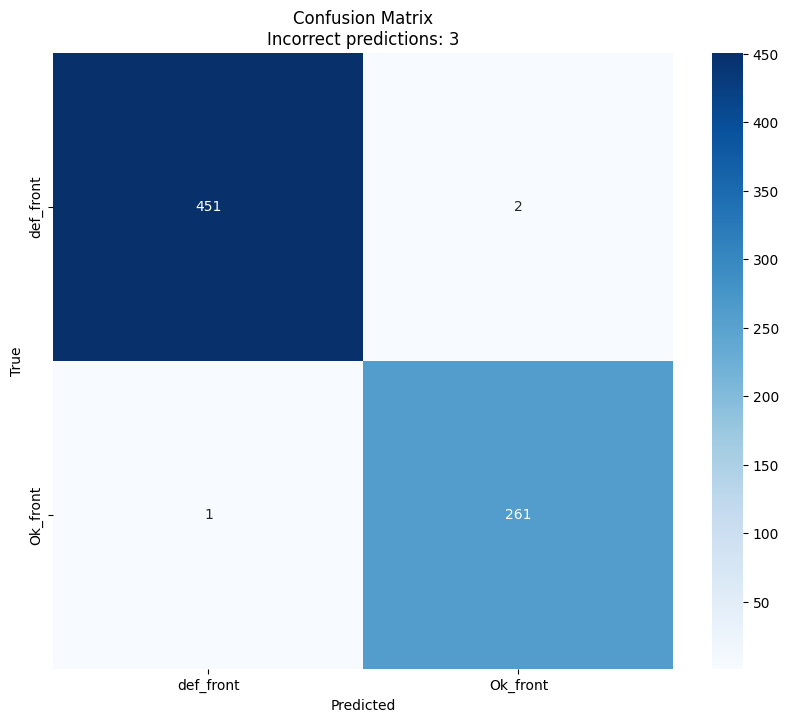

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 재현 가능한 결과를 위해 랜덤 시드 설정
torch.manual_seed(42)
np.random.seed(42)

# 변수 초기화
num_correct = 0
num_total = 0
num_incorrect = 0

# 클래스별 정답 개수 및 맞춘 개수를 저장할 리스트 초기화
class_correct = [0] * num_classes
class_total = [0] * num_classes

# 실제 클래스와 예측된 클래스를 저장할 리스트 초기화
true_classes = []
predicted_classes = []

# 예측 수행
with torch.no_grad():
    model_ft.eval()
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)

        # 정확도 및 잘못 분류된 이미지 개수 계산
        num_correct += torch.sum(predicted == labels).item()
        num_total += labels.size(0)
        num_incorrect += torch.sum(predicted != labels).item()

        # 클래스별 정답 개수 및 맞춘 개수 계산
        for i in range(len(predicted)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            
        # 실제 클래스와 예측된 클래스 저장
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# 정확도 계산
accuracy = num_correct / num_total

# 결과 출력
if num_incorrect == 0:
    print("No incorrectly classified images")
else:
    print("Number of incorrectly classified images:", num_incorrect)

print("Accuracy:", accuracy)

# 클래스별 정답 개수 및 맞춘 개수 출력
for i in range(num_classes):
    print('Accuracy of %s : %d/%d' % (classes[i], class_correct[i], class_total[i]))

# Confusion Matrix 생성
cm = confusion_matrix(true_classes, predicted_classes)

# 클래스 이름 설정
class_names = classes

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix\nIncorrect predictions: {}'.format(num_incorrect))  # 잘못 예측한 이미지 수 포함
plt.show()

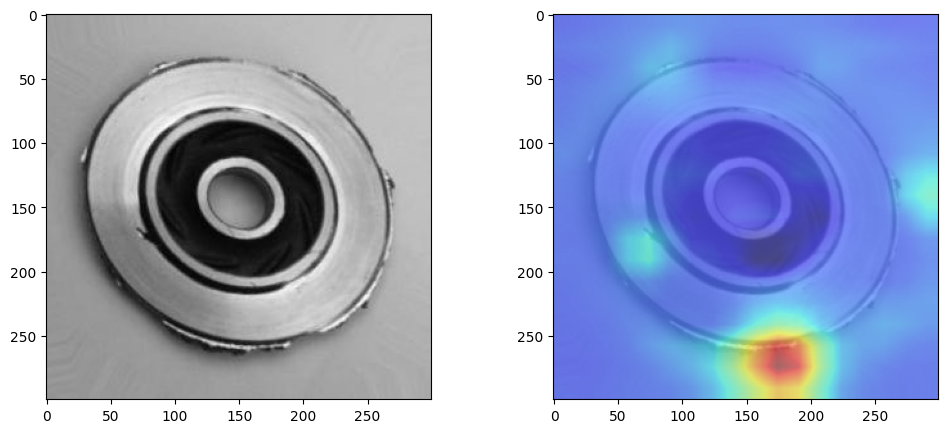

In [96]:
from captum.attr import IntegratedGradients, GuidedGradCam, LayerGradCam, LayerDeepLift
# from captum.attr.visualization import visualize_image_attr
from torchvision.io import read_image
from PIL import Image
import cv2

class_names = ("def_front","Ok_front")

net = model_ft
guided_gc = LayerGradCam(net, net.features[29])

foldername = os.path.join(data_dir, 'test/' + class_names[0])
imagename = np.random.choice(os.listdir(foldername), 1)[0]

img = Image.open(os.path.join(foldername, imagename))
im = np.asarray(img)

img = data_transforms['test'](img)

input = img.reshape((1,)+img.shape)
input = input.to(device)
input.requires_grad = True


# Computes guided GradCAM attributions for class 3.
# attribution size matches input size, Nx3x32x32
attribution = guided_gc.attribute(input, target=0)


grid = attribution.cpu().detach().numpy()[0,:,:,:].transpose((1,2,0))
grid = 255 * ( (grid -  grid.min()) / (grid.max() -  grid.min()) )
grid = grid.astype(np.uint8)
grid = cv2.resize(grid, (300, 300), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
plt.show()

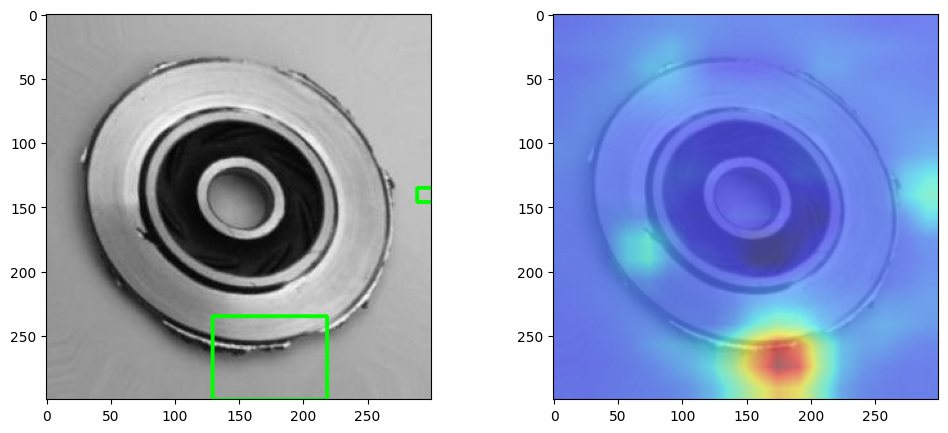

In [97]:
threshold = 100 # 임계값 설정

# threshold 이상의 값을 가지는 영역을 구합니다.
thresholded_grid = np.where(grid > threshold, grid, 0)

# threshold 이상의 값을 가지는 영역을 bounding box로 표시합니다.
contours, _ = cv2.findContours(thresholded_grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 이미지를 복사하여 수정 가능한 형태로 만듭니다.
im_copy = im.copy()

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(im_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_copy)

plt.subplot(1, 2, 2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
plt.show()